In [3]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.python.framework import ops

In [4]:
# Discriminator Net, hidden layer nodes = 128
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[784, None])

D_W1 = tf.get_variable('D_W1', [128, 784], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
D_b1 = tf.get_variable('D_b1', [128, 1], initializer = tf.zeros_initializer())

D_W2 = tf.get_variable('D_W2', [1, 128], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
D_b2 = tf.get_variable('D_b2', [1, 1], initializer = tf.zeros_initializer())

theta_D = [D_W1, D_W2, D_b1, D_b2]

# Generator Net, hidden layer nodes = 128
Z = tf.placeholder(tf.float32, shape=[100, None])

G_W1 = tf.get_variable('G_W1', [128, 100], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
G_b1 = tf.get_variable('G_b1', [128, 1], initializer = tf.zeros_initializer())

G_W2 = tf.get_variable('G_W2', [784, 128], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
G_b2 = tf.get_variable('G_b2', [784, 1], initializer = tf.zeros_initializer())

theta_G = [G_W1, G_W2, G_b1, G_b2]


In [122]:
#Test script
with tf.Session() as sess:
    print(D_W1)
    print(D_b1)
    print(D_W2)
    print(D_b2)
    print(G_W1)  
    print(G_b1)
    print(G_W2)
    print(G_b2)
    print(X)
    print(Z)
    

<tf.Variable 'D_W1:0' shape=(128, 784) dtype=float32_ref>
<tf.Variable 'D_b1:0' shape=(128, 1) dtype=float32_ref>
<tf.Variable 'D_W2:0' shape=(1, 128) dtype=float32_ref>
<tf.Variable 'D_b2:0' shape=(1, 1) dtype=float32_ref>
<tf.Variable 'G_W1:0' shape=(128, 100) dtype=float32_ref>
<tf.Variable 'G_b1:0' shape=(128, 1) dtype=float32_ref>
<tf.Variable 'G_W2:0' shape=(784, 128) dtype=float32_ref>
<tf.Variable 'G_b2:0' shape=(784, 1) dtype=float32_ref>
Tensor("Placeholder:0", shape=(784, ?), dtype=float32)
Tensor("Placeholder_1:0", shape=(100, ?), dtype=float32)


In [5]:
# Define random inputs for Generator
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [6]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(G_W1, z) + G_b1)
    G_log_prob = tf.matmul(G_W2, G_h1) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [125]:
# test script
tf.reset_default_graph()

with tf.Session() as sess:
    print(generator(Z))

Tensor("Sigmoid:0", shape=(784, ?), dtype=float32)


In [7]:
def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(D_W1, x) + D_b1)
    D_logit = tf.matmul(D_W2, D_h1) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [143]:
# test script
tf.reset_default_graph()

with tf.Session() as sess:
    print(discriminator(X))

(<tf.Tensor 'Sigmoid_3:0' shape=(1, ?) dtype=float32>, <tf.Tensor 'add_8:0' shape=(1, ?) dtype=float32>)


In [8]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    
    samples = np.transpose(samples)
    
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [9]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# we use negative sign for the loss functions because they need to be maximized
# whereas TensorFlow’s optimizer can only do minimization.
# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Iter: 0
D loss: 1.836
G_loss: 1.946



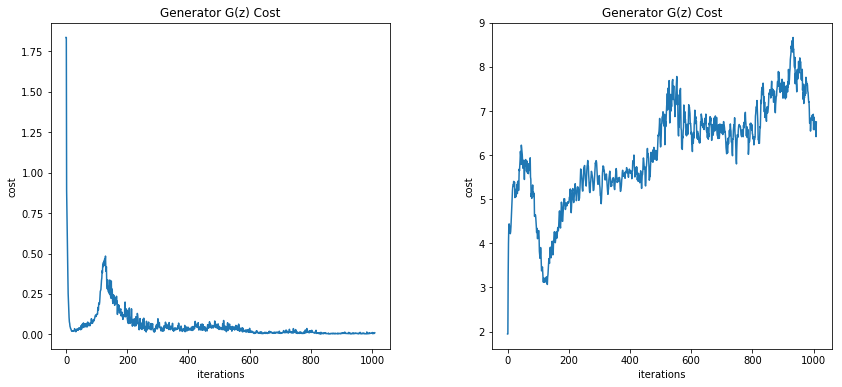

In [15]:
mb_size = 128
Z_dim = 100

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    if not os.path.exists('out/'):
        os.makedirs('out/')

    i = 0

    D_cost = []
    G_cost =[]

    for it in range(1000):
        if it % 1000 == 0:
            samples = sess.run(G_sample, feed_dict={Z: sample_Z(Z_dim, 16)})

            fig = plot(samples)
            plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
            i += 1
            plt.close(fig)

        X_mb, _ = mnist.train.next_batch(mb_size)
        X_mb = np.transpose(X_mb)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(Z_dim, mb_size)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(Z_dim, mb_size)})

        D_cost.append(D_loss_curr)
        G_cost.append(G_loss_curr)

        if it % 1000 == 0:
            print('Iter: {}'.format(it))
            print('D loss: {:.4}'. format(D_loss_curr))
            print('G_loss: {:.4}'.format(G_loss_curr))
            print()
        if it % 100 == 0:
            D_cost.append(D_loss_curr)
            G_cost.append(G_loss_curr)          
        
plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
plt.plot(np.squeeze(D_cost))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Generator G(z) Cost")

plt.subplot(1,2,2)
plt.plot(np.squeeze(G_cost))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Generator G(z) Cost")
plt.subplots_adjust(wspace=0.3);